In [57]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

import torchvision.transforms as transforms

DATASET_FOLDER = "./data/"
IMAGE_FOLDER = 'images/'

In [3]:
path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df_train = pd.read_csv(path_csv)

df_train.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [4]:
for image_id in tqdm(df_train['image_id']):
    try:
        img_path = os.path.join(DATASET_FOLDER, IMAGE_FOLDER, image_id)
        image = Image.open(f'{img_path}.png')
    except:
        print(f'Image {image_id} does not exist')

100%|██████████| 754/754 [00:00<00:00, 6088.94it/s]


## Pie Chart

Data is imbalanced

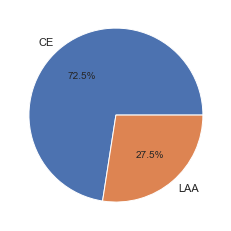

In [5]:
counts = df_train[["label"]].value_counts().reset_index()
values = counts[0].values
labels = counts['label'].values

plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.show()

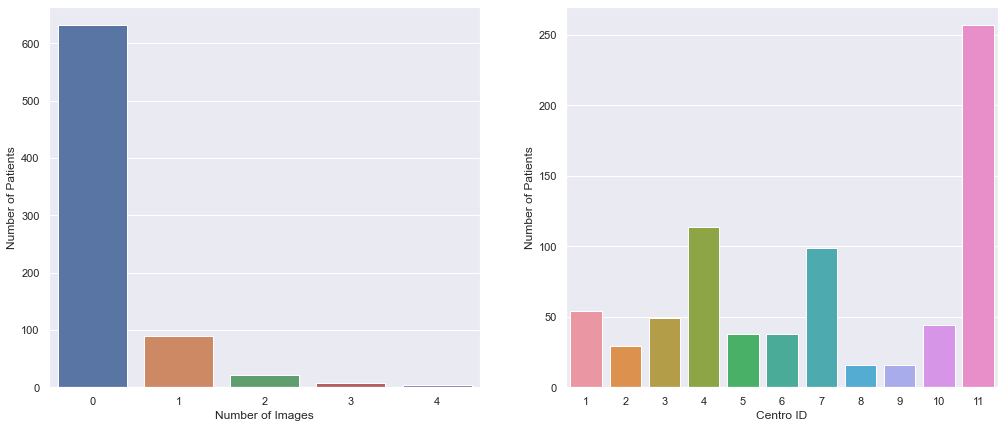

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

'''counts_image_num = df_train[["image_num"]].value_counts().reset_index()
values_image_num = counts_image_num[0].values
labels_image_num = counts_image_num['image_num'].values + 1

sns.barplot(x=labels_image_num, y=values_image_num, ax=axes[0])
axes[0].set_ylabel('Number of Patients')
axes[0].set_xlabel('Number of Images')

counts_center_id = df_train[["center_id"]].value_counts().reset_index()
values_center_id = counts_center_id[0].values
labels_center_id = counts_center_id['center_id'].values

sns.barplot(x=labels_center_id, y=values_center_id, ax=axes[1])
axes[1].set_ylabel('Number of Patients')
axes[1].set_xlabel('Centro ID')'''

sns.countplot(x='image_num', data=df_train, ax=axes[0])
axes[0].set_ylabel('Number of Patients')
axes[0].set_xlabel('Number of Images')

sns.countplot(x='center_id', data=df_train, ax=axes[1])
axes[1].set_ylabel('Number of Patients')
axes[1].set_xlabel('Centro ID')

plt.show()

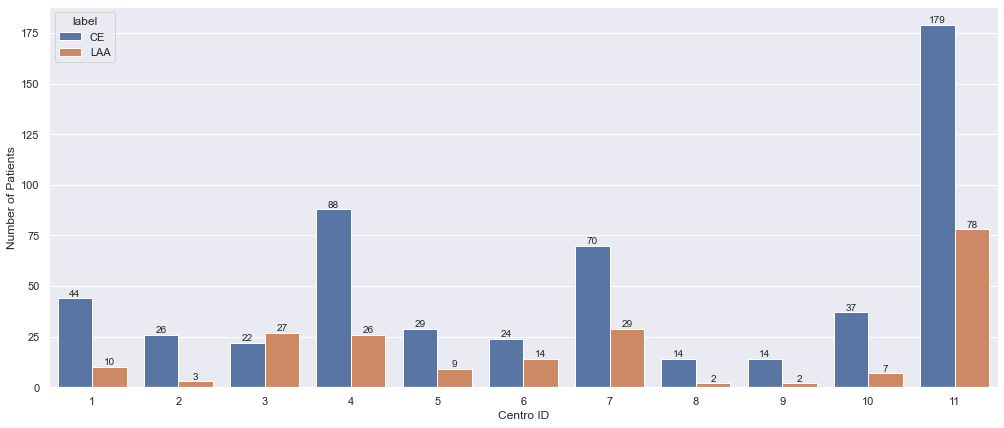

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 7))

sns.countplot(x='center_id', hue='label', data=df_train, ax=ax)
for container in ax.containers: ax.bar_label(container)
ax.set_ylabel('Number of Patients')
ax.set_xlabel('Centro ID')

plt.show()

## Images

In [6]:
sizes = []
for name in tqdm(df_train["image_id"]):
    img = Image.open(os.path.join(DATASET_FOLDER, IMAGE_FOLDER, f"{name}.png"))
    sizes.append({"img_height": img.height, "img_width": img.width})

df_sizes = pd.DataFrame(sizes)
for col in df_sizes.columns:
    df_train[col] = df_sizes[col]

100%|██████████| 754/754 [00:00<00:00, 39114.26it/s]


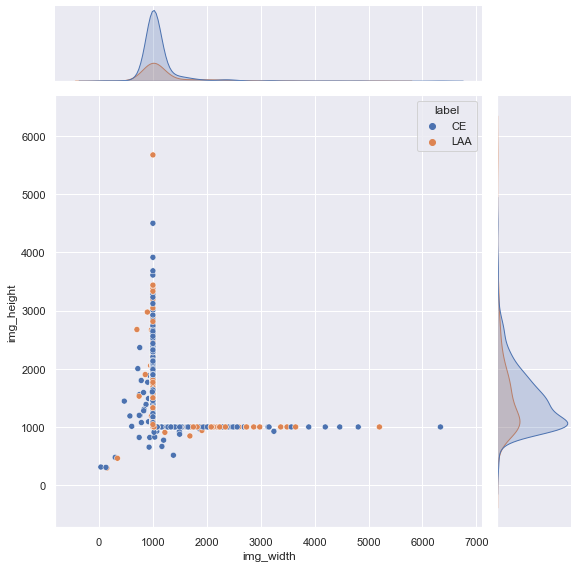

In [7]:
sns.jointplot(data=df_train, x="img_width", y="img_height", hue="label", height=8)

plt.show()

In [8]:
ROUND_VALUES = False

df_sizes = df_train[["img_width", "img_height", "label"]]

if ROUND_VALUES:
    for col in ("img_width", "img_height"):
        df_sizes[col] = [round(i / 2000) * 2000 for i in df_sizes[col]]

df_sizes = df_sizes.groupby(["img_width", "img_height", "label"], as_index=False).size()
# display(df_sizes.head())
fig = px.scatter(df_sizes, x="img_width", y="img_height", size="size", color="label", height=600, width=600)
fig.update_xaxes(range=[0, df_sizes['img_width'].max()])
fig.update_yaxes(scaleanchor="x", scaleratio=1, range=[0, df_sizes['img_height'].max()])
fig.show() 

3it [00:00, 25.77it/s]
3it [00:00, 17.73it/s]


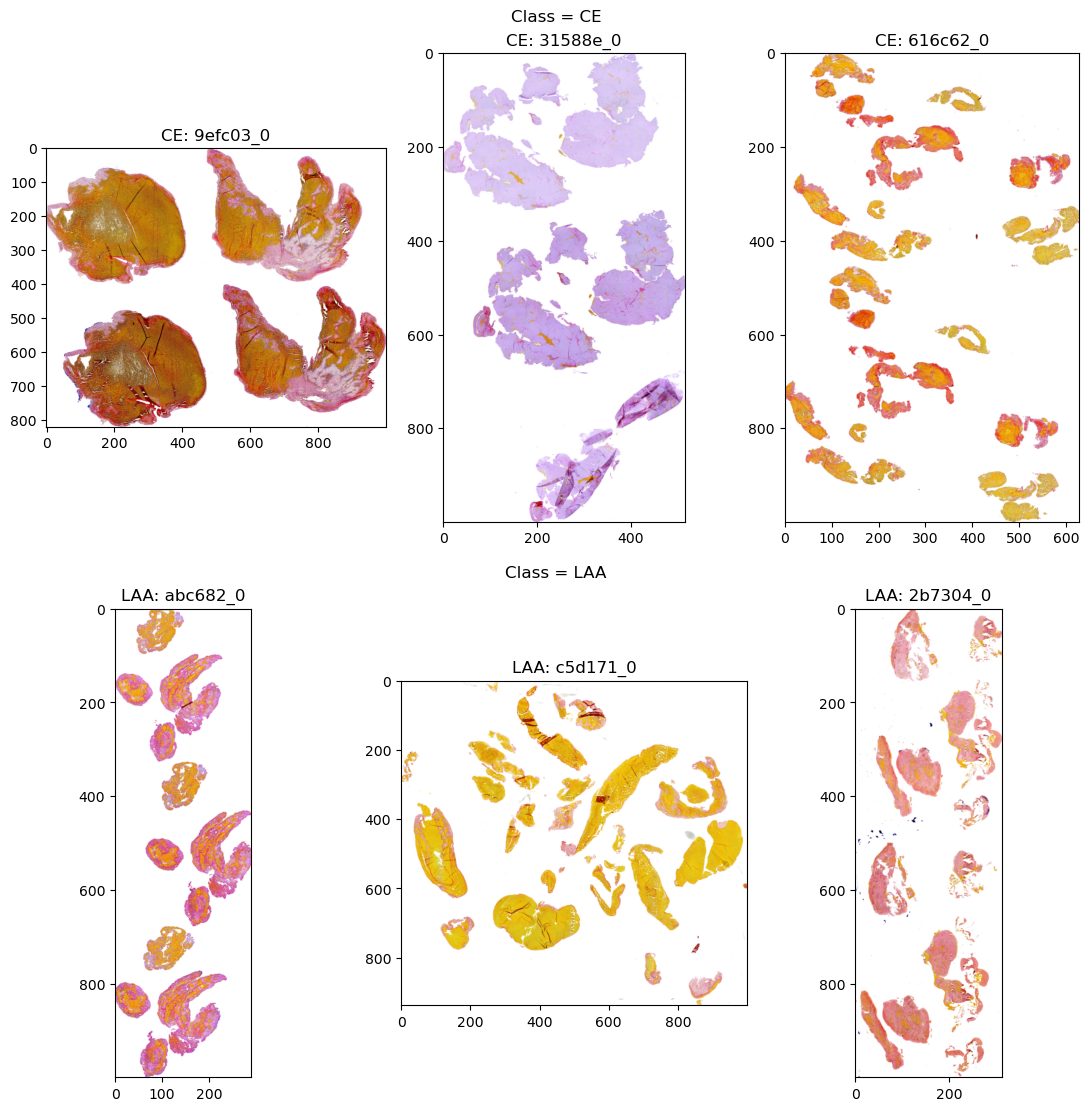

In [12]:
sns.reset_orig()

fig = plt.figure(figsize=(11, 11), constrained_layout=True)

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, info in enumerate(zip(subfigs, df_train.groupby("label"))):
    subfig = info[0]
    label = info[1][0]
    df = info[1][1]

    subfig.suptitle(f'Class = {label}')

    axs = subfig.subplots(nrows=1, ncols=3)
    for col, name in tqdm(enumerate(df["image_id"].sample(3))):
        img_path = os.path.join(DATASET_FOLDER, IMAGE_FOLDER, name)
        img = Image.open(f'{img_path}.png')
        
        img.thumbnail((1000, 1000), resample=Image.Resampling.BILINEAR, reducing_gap=20)
        
        axs[col].imshow(img)
        axs[col].set_title(f"{label}: {name}")
        
plt.show()

In [139]:
def plot(df, img_dir, center_id, base_transform, aug_transform):
    center_id_patients = df[df['center_id'] == center_id]
    labels = ['CE', 'LAA']
    
    fig = plt.figure(figsize=(9, 7), constrained_layout=True)
    subfigs = fig.subfigures(nrows=2, ncols=1)
    
    for row, info in enumerate(zip(subfigs, labels)):
        subfig = info[0]
        label = info[1]
        df = center_id_patients[center_id_patients['label'] == label]

        subfig.suptitle(f'Class = {label}')

        axs = subfig.subplots(nrows=1, ncols=5)
        
        image_id = df["image_id"].sample(1).values[0]
        img_path = os.path.join(img_dir, f'{image_id}.png')
        img = Image.open(img_path)
        img_base_transform = base_transform(img).permute(1, 2, 0)
        img_aug_transform1 = aug_transform(img).permute(1, 2, 0)
        img_aug_transform2 = aug_transform(img).permute(1, 2, 0)
        img_aug_transform3 = aug_transform(img).permute(1, 2, 0)
        
        img.thumbnail((1000, 1000), resample=Image.Resampling.BILINEAR, reducing_gap=20)
            
        axs[0].imshow(img)
        axs[0].set_title(f"Original Image")
        
        axs[1].imshow(img_base_transform)
        axs[1].set_title(f"Base Transformation")
        
        axs[2].imshow(img_aug_transform1)
        axs[2].set_title(f"Augmentation Transformation")
        
        axs[3].imshow(img_aug_transform2)
        axs[3].set_title(f"Augmentation Transformation")
        
        axs[4].imshow(img_aug_transform3)
        axs[4].set_title(f"Augmentation Transformation")
        
    #plt.tight_layout()
            

In [140]:
base_transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.9454, 0.8770, 0.8563), std=(0.1034, 0.2154, 0.2716))
])

aug_transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.9454, 0.8770, 0.8563), std=(0.1034, 0.2154, 0.2716))
])


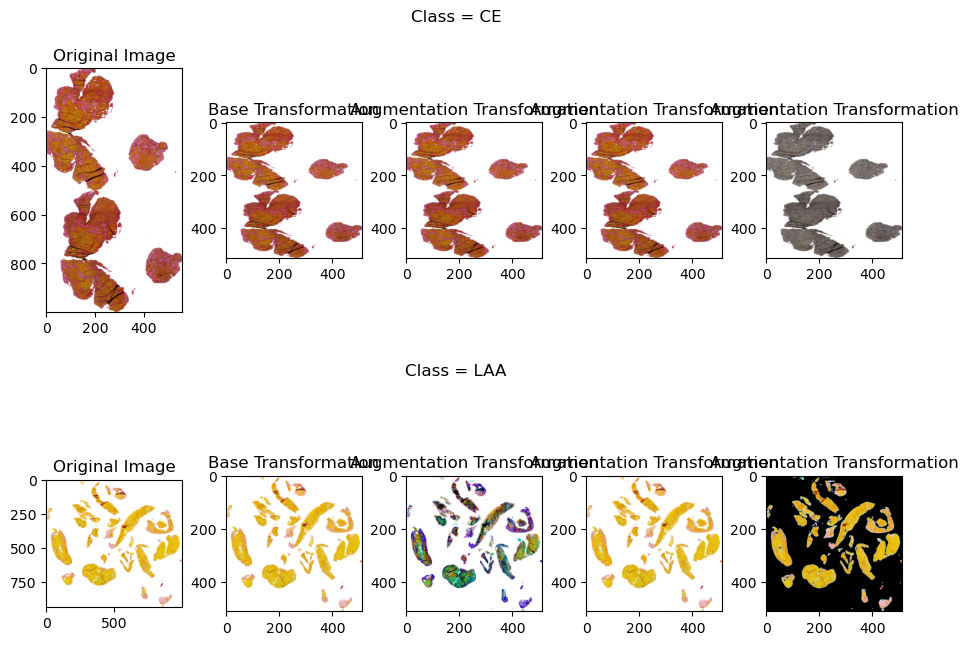

In [143]:
sns.reset_orig()

a = plot(
    df=df_train, 
    img_dir=f'{DATASET_FOLDER}{IMAGE_FOLDER}', 
    center_id=1, 
    base_transform=base_transform, 
    aug_transform=aug_transform
)

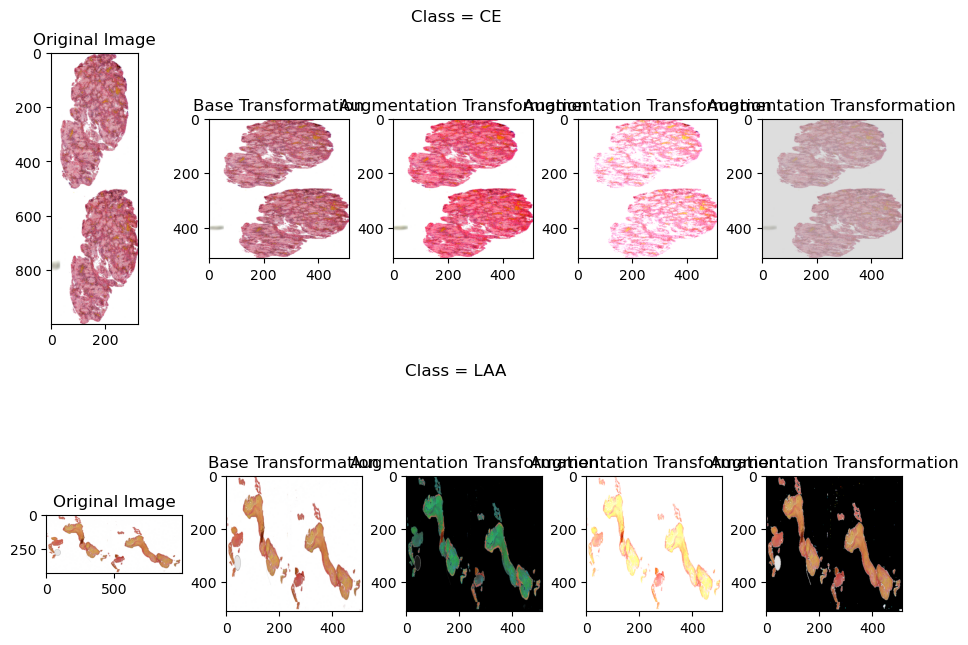

In [144]:
a = plot(
    df=df_train, 
    img_dir=f'{DATASET_FOLDER}{IMAGE_FOLDER}', 
    center_id=2, 
    base_transform=base_transform, 
    aug_transform=aug_transform
)

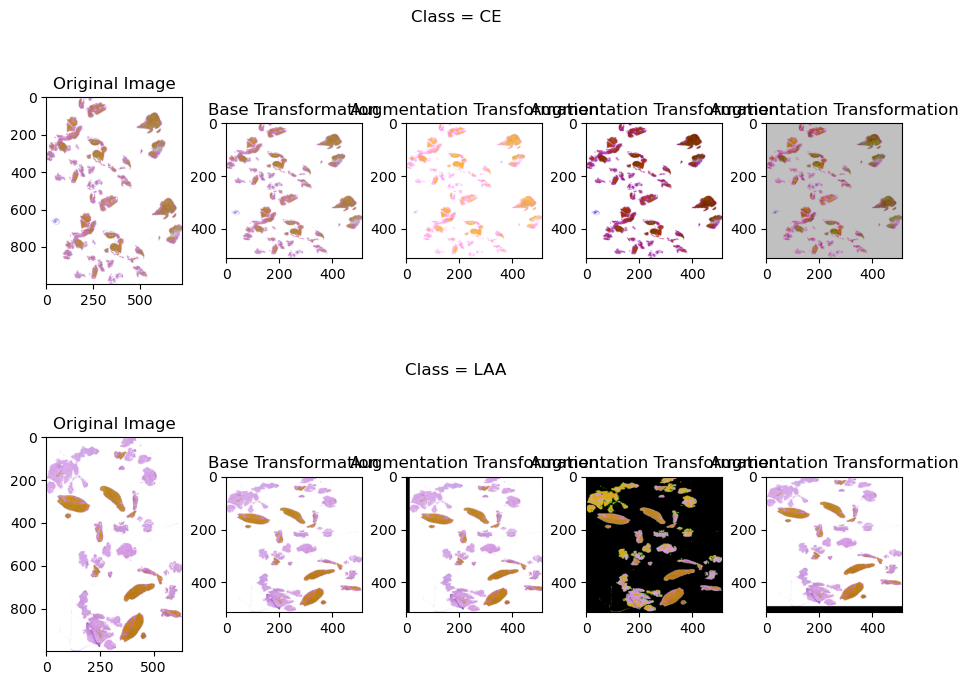

In [146]:
a = plot(
    df=df_train, 
    img_dir=f'{DATASET_FOLDER}{IMAGE_FOLDER}', 
    center_id=7, 
    base_transform=base_transform, 
    aug_transform=aug_transform
)